In [1]:
import concurrent.futures
import glob
import os
import re
import subprocess
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import circmean
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
def calculate_heading_difference(pre_heading, post_heading):
    # Calculate the angular difference considering the circular nature
    diff = post_heading - pre_heading
    
    # Normalize to [-π, π] range
    return np.arctan2(np.sin(diff), np.cos(diff))

In [3]:
# Base folder with all slp files
slp_base_folder = "/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/"

# Folders with CS and native SLP files
cs_slp_folder = os.path.join(slp_base_folder, "wildtype-cs")
native_slp_folder = os.path.join(slp_base_folder, "native")

# Get all subfolders in the CS and native SLP folders
cs_slp_subfolders = sorted(glob.glob(os.path.join(cs_slp_folder, "*")))
native_slp_subfolders = sorted(glob.glob(os.path.join(native_slp_folder, "*")))

# Output folder
cs_output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/"
native_output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/"

In [1]:
# Define a worker function that processes a single file
def process_file(file_info):
    file, exp_output_folder = file_info  # Unpack the tuple

    # set the output filename
    output_file = os.path.join(
        exp_output_folder, os.path.basename(file).replace(".slp", ".csv")
    )

    # if file exists, skip
    if os.path.exists(output_file):
        return f"Skipping {file} (already converted)"

    # convert to csv
    cmd = ["sleap-convert", file, "--format", "analysis.csv", "--output", output_file]

    # To log output to a file instead of discarding it
    with open(os.path.join(exp_output_folder, "conversion.log"), "a") as log_file:
        subprocess.run(cmd, stdout=log_file, stderr=log_file)

    return f"Converted {file}"


def process_folders(input_folders, output_folders):
    # loop over all exp folders
    for exp_folder in input_folders:
        # find all slp files in each folder
        exp_files = sorted(glob.glob(os.path.join(exp_folder, "*.slp")))

        # setup output folder (same name as exp_folder)
        exp_output_folder = os.path.join(
            cs_output_folder, os.path.basename(os.path.normpath(exp_folder))
        )
        os.makedirs(exp_output_folder, exist_ok=True)

        # Prepare input data for process_map
        file_data = [(file, exp_output_folder) for file in exp_files]

        # Process files in parallel with progress bar using process_map
        results = process_map(
            process_file,
            file_data,
            max_workers=4,  # Adjust based on your system
            chunksize=10,  # Process files in batches of 10
            desc=f"Processing {os.path.basename(exp_folder)}",
            leave=True,
        )


# process_folders(native_slp_subfolders, native_output_folder)

In [25]:
# Create an empty list to collect all the data
all_data = []

pre_range = [0, 400]
post_range = [400, 750]

stim_csvs = sorted(glob.glob("./canton-s/*.csv"))
pattern = r"obj_id_(\d+)_frame_(\d+)"

for stim_csv in stim_csvs:
    print(f"==== Processing {stim_csv} ====")
    stim_df = pd.read_csv(stim_csv)
    folder = os.path.join("./canton-s/",
        os.path.join(os.path.basename(os.path.normpath(stim_csv)).replace(".csv", ""))
        )
    
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    
    for idx, row in stim_df.iterrows():
        # extract data for each stim row
        stim_obj_id = int(row["obj_id"])
        stim_frame = int(row["frame"])
        stim_heading = float(row["stim_heading"])
        
        # Find the matching file by simple linear search
        matching_file = None
        for file in files:
            match = re.search(pattern, file)
            if match:
                file_obj_id = int(match.group(1))
                file_frame = int(match.group(2))
                
                if file_obj_id == stim_obj_id and file_frame == stim_frame:
                    matching_file = file
                    break
        
        # if no matching file was found, skip
        if matching_file is None:
            continue

        # Load the matching file
        data_df = pd.read_csv(matching_file)

        # interpolate missing values
        data_df_interp = data_df.interpolate(method="linear", limit_direction="both", limit=10)

        # extract all data
        frames = data_df_interp["frame_idx"].to_numpy()
        head_x = data_df_interp["head.x"].to_numpy()
        head_y = data_df_interp["head.y"].to_numpy()
        abdomen_x = data_df_interp["abdomen.x"].to_numpy()
        abdomen_y = data_df_interp["abdomen.y"].to_numpy()

        # get indices
        pre_indices = np.where((frames >= pre_range[0]) & (frames < pre_range[1]))[0]
        post_indices = np.where((frames >= post_range[0]) & (frames < post_range[1]))[0]

        # Skip if no data in these ranges
        if len(pre_indices) == 0 or len(post_indices) == 0:
            continue
        
        # get pre data
        head_x_pre = head_x[pre_indices]
        head_y_pre = head_y[pre_indices]
        abdomen_x_pre = abdomen_x[pre_indices]
        abdomen_y_pre = abdomen_y[pre_indices]

        # get post data
        head_x_post = head_x[post_indices]
        head_y_post = head_y[post_indices]
        abdomen_x_post = abdomen_x[post_indices]
        abdomen_y_post = abdomen_y[post_indices]

        # calculate heading
        pre_heading = np.arctan2(head_y_pre - abdomen_y_pre, head_x_pre - abdomen_x_pre)
        post_heading = np.arctan2(head_y_post - abdomen_y_post, head_x_post - abdomen_x_post)
        
        # get mean pre and post heading
        pre_heading_mean = circmean(pre_heading, high=np.pi, low=-np.pi)
        post_heading_mean = circmean(post_heading, high=np.pi, low=-np.pi)

        # calculate heading difference
        try:
            prepost_heading_difference = calculate_heading_difference(post_heading_mean, pre_heading_mean)
            # calculate heading difference between pre_heading and stim_heading
            prestim_heading_difference = calculate_heading_difference(stim_heading, pre_heading_mean)
            
            # Create a copy of the row data and add the new calculations
            row_data = row.to_dict()  # Convert the row to a dictionary
            row_data['prepost_heading_difference'] = prepost_heading_difference
            row_data['prestim_heading_difference'] = prestim_heading_difference
            
            # Append to the all_data list
            all_data.append(row_data)
            
        except ValueError as e:
            print(f"Error calculating heading difference: {e}")
            continue

# Create a DataFrame from all the collected data
result_df = pd.DataFrame(all_data)

# Now result_df contains all the data from all files with the heading differences
print(f"Combined DataFrame has {len(result_df)} rows")

==== Processing ./canton-s/20241121_151406.csv ====
==== Processing ./canton-s/20241126_171308.csv ====
==== Processing ./canton-s/20241130_161634.csv ====
==== Processing ./canton-s/20250102_152013.csv ====
==== Processing ./canton-s/20250110_142709.csv ====
==== Processing ./canton-s/20250111_151946.csv ====
Combined DataFrame has 89 rows


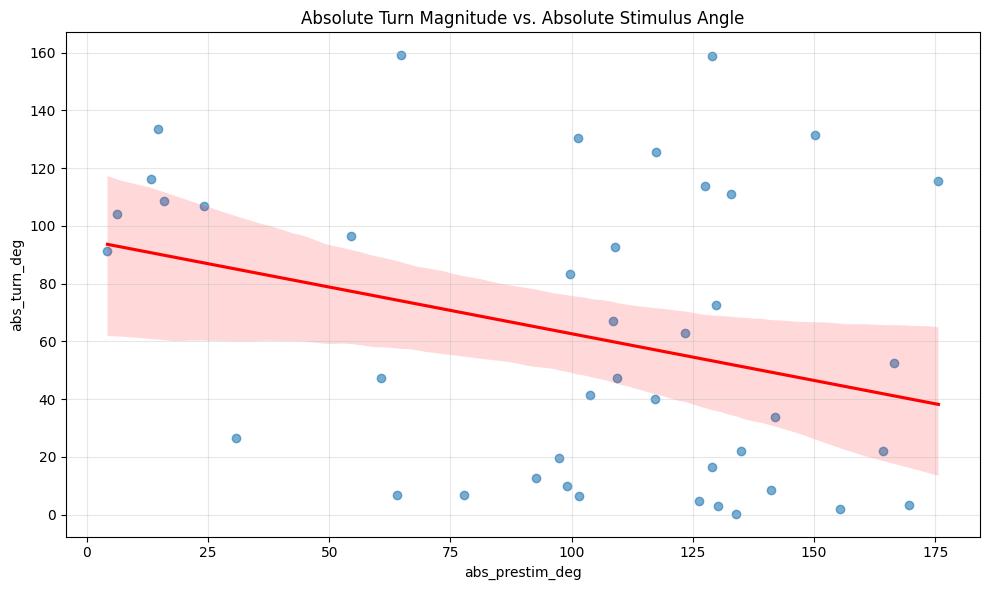

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Calculate absolute values
result_df['abs_prestim_diff'] = np.abs(result_df['prestim_heading_difference'])
result_df['abs_turn_magnitude'] = np.abs(result_df['prepost_heading_difference'])

# Convert to degrees for easier interpretation
result_df['abs_prestim_deg'] = np.degrees(result_df['abs_prestim_diff'])
result_df['abs_turn_deg'] = np.degrees(result_df['abs_turn_magnitude'])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(result_df['abs_prestim_deg'], result_df['abs_turn_deg'], alpha=0.6)
plt.xlabel('|Stimulus Direction Relative to Animal| (degrees)')
plt.ylabel('|Turn Magnitude| (degrees)')
plt.title('Absolute Turn Magnitude vs. Absolute Stimulus Angle')
plt.grid(True, alpha=0.3)

# Add trend line
sns.regplot(x='abs_prestim_deg', y='abs_turn_deg', data=result_df, 
            scatter=False, color='red')

plt.tight_layout()
plt.show()

/tmp/ipykernel_263389/1268495239.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = result_df.groupby('angle_bin')['abs_turn_deg'].agg(


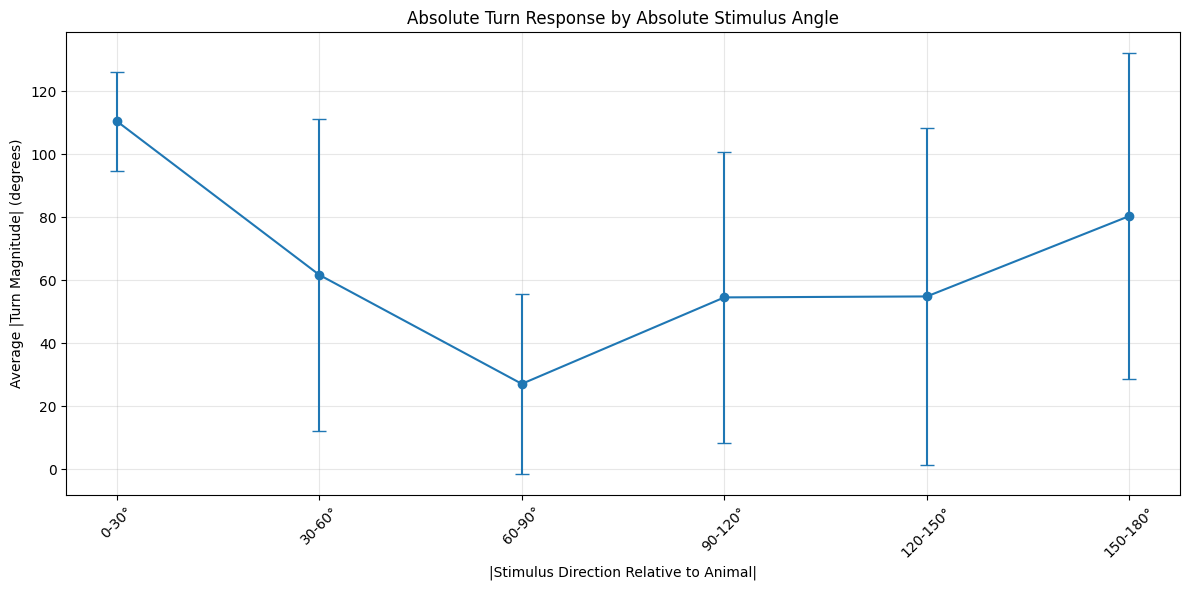

In [23]:
# Create bins for absolute stimulus direction difference (in degrees)
bins = np.linspace(0, 180, 7)  # 6 bins from 0 to 180 degrees
labels = ['0-30°', '30-60°', '60-90°', '90-120°', '120-150°', '150-180°']

# Bin the data
result_df['angle_bin'] = pd.cut(result_df['abs_prestim_deg'], 
                               bins=bins, labels=labels, include_lowest=True)

# Calculate statistics for each bin
bin_stats = result_df.groupby('angle_bin')['abs_turn_deg'].agg(
    ['mean', 'std', 'count']).reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(bin_stats['angle_bin'], bin_stats['mean'], 
             yerr=bin_stats['std'], fmt='o-', capsize=5)
plt.xlabel('|Stimulus Direction Relative to Animal|')
plt.ylabel('Average |Turn Magnitude| (degrees)')
plt.title('Absolute Turn Response by Absolute Stimulus Angle')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_263389/3215006442.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_stats = result_df.groupby('stim_position')['abs_turn_deg'].agg(


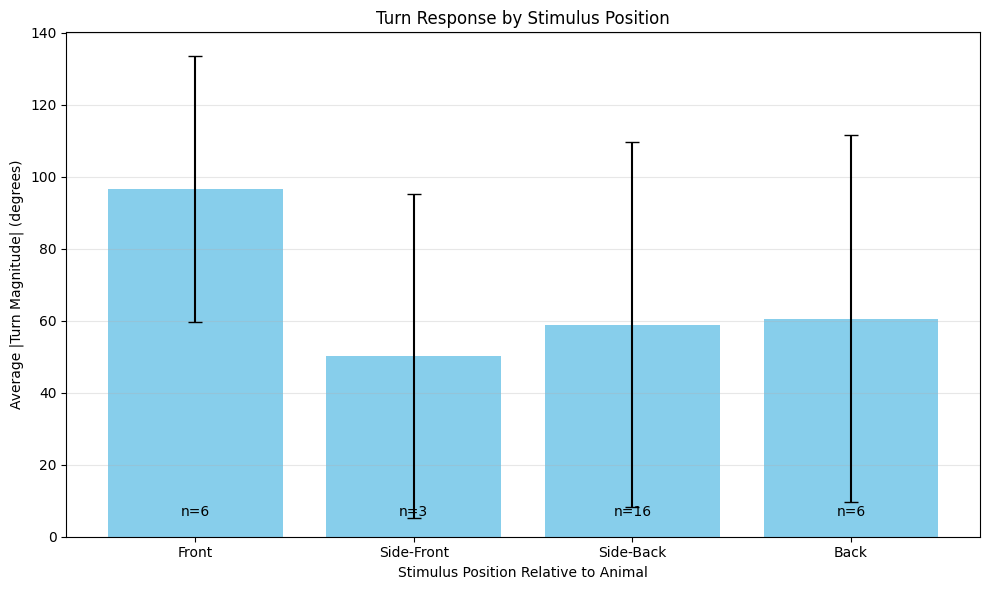

In [24]:
# Create simpler groups for analysis
result_df['stim_position'] = pd.cut(
    result_df['abs_prestim_deg'], 
    bins=[0, 45, 90, 135, 180], 
    labels=['Front', 'Side-Front', 'Side-Back', 'Back']
)

# Group by stimulus position and calculate mean turn
position_stats = result_df.groupby('stim_position')['abs_turn_deg'].agg(
    ['mean', 'std', 'count']).reset_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(position_stats['stim_position'], position_stats['mean'], 
        yerr=position_stats['std'], capsize=5, color='skyblue')

# Add count labels on bars
for i, bar in enumerate(bars):
    count = position_stats['count'].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, 5, 
             f'n={count}', ha='center', va='bottom')

plt.xlabel('Stimulus Position Relative to Animal')
plt.ylabel('Average |Turn Magnitude| (degrees)')
plt.title('Turn Response by Stimulus Position')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [17]:
def unwrap_with_nan(array):
    array[~np.isnan(array)] = np.unwrap(array[~np.isnan(array)])
    return array

In [18]:
def sg_smooth(array, window_length=51, polyorder=3, **kwargs):
    return savgol_filter(
        array, window_length=window_length, polyorder=polyorder, **kwargs
    )